<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/25_august_2021_fixes/C4/W4/assignment/C4_W4_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O ./daily-min-temperatures.csv

./daily-min-temperatures.csv: No such file or directory


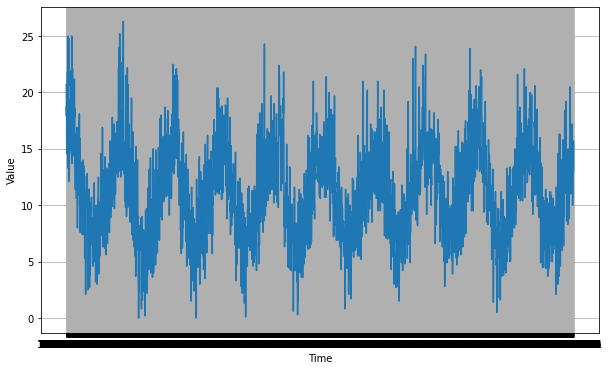

In [6]:
import csv
time_step = []
temps = []

with open('./data/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)
    time_step, temps = tuple(map(list, zip(*reader)))
    temps = list(map(float, temps))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

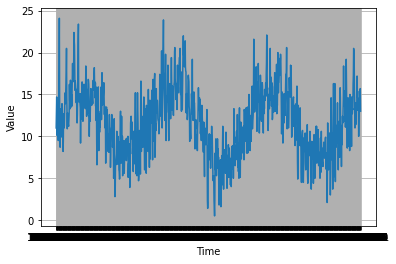

In [7]:
plot_series(time[2500:], series[2500:])

In [8]:
split_time = 2500
time_train = time[:2500]
x_train = series[:2500]
time_valid = time[2500:]
x_valid = series[2500:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    return (
        tf.data.Dataset.from_tensor_slices(tf.expand_dims(series, axis=-1))
            .window(window_size + 1, shift=1, drop_remainder=True)
            .flat_map(lambda window: window.batch(window_size + 1))
            .shuffle(shuffle_buffer)
            .map(lambda x: (x[:-1], x[1:]), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE)
    )

In [19]:
def model_forecast(model, series, window_size):
    return model.predict(
        tf.data.Dataset.from_tensor_slices(series)
            .window(window_size, shift=1, drop_remainder=True)
            .flat_map(lambda window: window.batch(window_size))
            .batch(32)
            .prefetch(tf.data.AUTOTUNE)
    )

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

import tensorflow_datasets as tfds
a, b = (next(iter(tfds.as_numpy(train_set))))
print(a.shape)
print(b.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
(256, 64, 1)
(256, 64, 1)
Epoch 1/100
10/10 [==============================] - 3s 35ms/step - loss: 31.1568 - mae: 31.6547 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 27ms/step - loss: 30.5790 - mae: 31.0768 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 25ms/step - loss: 29.6831 - mae: 30.1806 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 25ms/step - loss: 28.5597 - mae: 29.0570 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 26ms/step - loss: 27.1984 - mae: 27.6955 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 25.5015 - mae: 25.9983 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 23.3459 - mae: 23.8423 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 25ms/step - loss: 

(1e-08, 0.0001, 0.0, 60.0)

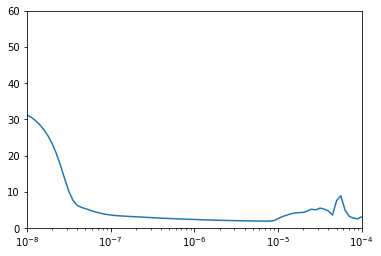

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 5, activation='relu', padding='causal', input_shape=[None, 1]),
    (tf.keras.layers.LSTM(64, return_sequences=True)),
    (tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.subplot(2, 1, 2)
plt.plot(history.history['mae'])
plt.show()

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS